In [75]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#Hyperparameters
num_epochs = 3
seed = 10
total_vocab = 5000
max_len = 50

#data pre-processing code
#import required data
dataset = pd.read_csv('Sentiment Analysis Dataset.csv', on_bad_lines = 'skip')
#split dataset into training and testing data
trn_text, tst_text, trn_sent, tst_sent = train_test_split(dataset['text'], dataset['sentiment'], 
                                                          shuffle = True, random_state = seed, stratify = dataset['sentiment'])

#load the model
model = keras.models.load_model('OPT_LSTM_model.h5')

print(dataset)

          ItemID  sentiment SentimentSource  \
0              1          0    Sentiment140   
1              2          0    Sentiment140   
2              3          1    Sentiment140   
3              4          0    Sentiment140   
4              5          0    Sentiment140   
...          ...        ...             ...   
1578614  1578623          1    Sentiment140   
1578615  1578624          1    Sentiment140   
1578616  1578625          0    Sentiment140   
1578617  1578626          0    Sentiment140   
1578618  1578627          0    Sentiment140   

                                                      text  
0                             is so sad for my APL frie...  
1                           I missed the New Moon trail...  
2                                  omg its already 7:30 :O  
3                  .. Omgaga. Im sooo  im gunna CRy. I'...  
4                 i think mi bf is cheating on me!!!   ...  
...                                                    ...  
1578614 

In [76]:
#declare the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(num_words = total_vocab, oov_token = 1)
#fit tokenizer vocabulary on the dataset
tokenizer.fit_on_texts(trn_text)
#convert dataset text into sequences
trn_seq_raw = tokenizer.texts_to_sequences(trn_text)
tst_seq_raw = tokenizer.texts_to_sequences(tst_text)
#pad sequences to fixed length
trn_seq = pad_sequences(trn_seq_raw, padding = 'post', maxlen = max_len)
tst_seq = pad_sequences(tst_seq_raw, padding = 'post', maxlen = max_len)

In [77]:
#create output
tst_output = model.predict(tst_seq)

12333/12333 [==============================] - 443s 36ms/step


In [78]:
from sklearn.metrics import classification_report


#round up model outputs for classification
tst_pred = []

for i in tst_output:
    tst_pred.append(round(i[0]))
#show the classification report
print(classification_report(y_pred = tst_pred, y_true = tst_sent.to_numpy()))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83    197110
           1       0.82      0.84      0.83    197545

    accuracy                           0.83    394655
   macro avg       0.83      0.83      0.83    394655
weighted avg       0.83      0.83      0.83    394655



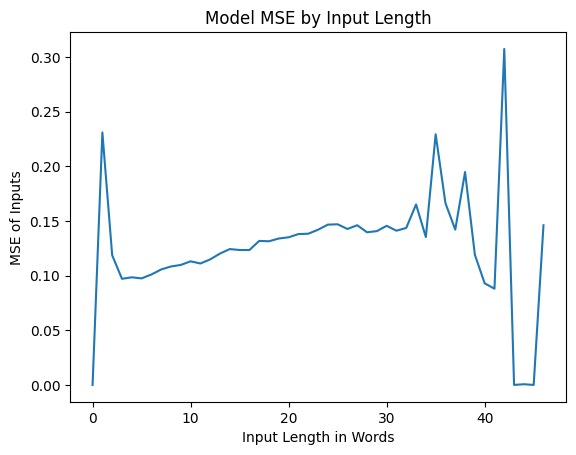

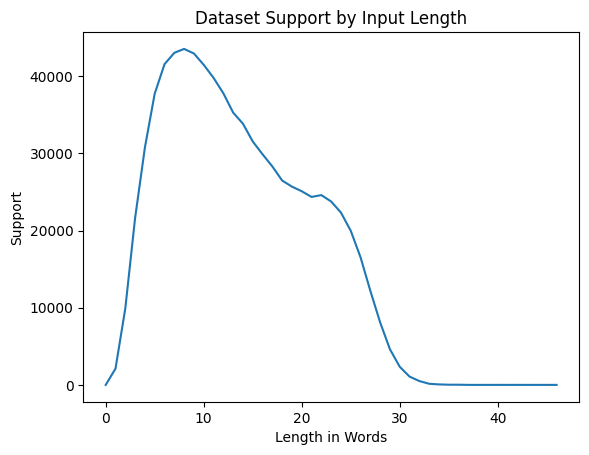

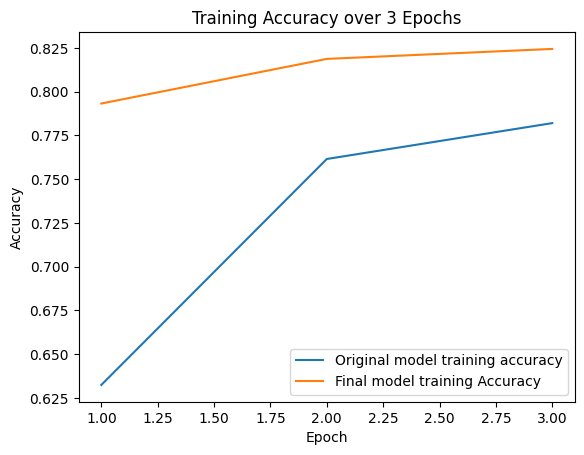

In [87]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

#convert these to numpy so theyre easier to use
trn_sent_arr = trn_sent.to_numpy()
tst_sent_arr = tst_sent.to_numpy()

#sort the prediction and ground truths by input length
tst_pred_by_len = [[0] for i in range(0, 47)]
tst_sent_by_len = [[0] for i in range(0, 47)]
trn_sent_by_len = [[0] for i in range(0, 47)]
len_support = [[0] for i in range(0, 47)]
for i in range(0, len(tst_seq_raw)):
    key = len(tst_seq_raw[i])
    tst_pred_by_len[key].append(tst_output[i][0])
    tst_sent_by_len[key].append(tst_sent_arr[i])
    trn_sent_by_len[key].append(trn_sent_arr[i])

#determine how many observations there are of each length, as well as the average error per length
tst_err_by_len = [[] for i in range(0, 47)]
for i in range(1, 47):
    tst_err_by_len[i] = mean_squared_error(tst_pred_by_len[i], tst_sent_by_len[i])
    len_support[i] = len(tst_sent_by_len[i]) + len(trn_sent_by_len[i])

#handle spurious columns
len_support[0] = 0
tst_err_by_len[0] = 0

#plot everything
plt.plot(tst_err_by_len)
plt.title("Model MSE by Input Length")
plt.xlabel("Input Length in Words")
plt.ylabel("MSE of Inputs")
plt.show()
plt.plot(len_support)
plt.title("Dataset Support by Input Length")
plt.ylabel("Support")
plt.xlabel("Length in Words")
plt.show()

plt.plot([1, 2, 3], [.6324, .7615, .7820], label = "Original model training accuracy")
plt.plot([1, 2, 3], [.7932, .8187, .8244], label = "Final model training Accuracy")
plt.title("Training Accuracy over 3 Epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()